### Downloading the corpus

In [39]:
from git import Repo
import os

git_url = "https://github.com/BlueBrain/corpus-thalamus.git"
repo_dir = os.path.join(os.getcwd(), "neurocuratorDB")
if not os.path.isdir(repo_dir):
    Repo.clone_from(git_url, repo_dir)
else:
    Repo(repo_dir).remotes.origin.pull()

### Imports

In [40]:
import sys
import os

# Imports from NeuroCurator code base
sys.path.append(os.path.join(os.getcwd(), ".."))

from glob import glob
#from qtNeurolexTree import TreeData
from nat.treeData import flatten_list
from nat.annotation import Annotation
from nat.modelingParameter import getParameterTypeFromID
from nat.variable import NumericalVariable

import pandas as pd
import numpy as np

### Loading all the annotations from the corpus

In [41]:
annotations = []
for fileName in glob("./neurocuratorDB/*.pcr"):
    try:
        annotations.extend(Annotation.readIn(open(fileName, "r", encoding="utf-8", errors='ignore')))
    except:       
        print("Skipping: ", fileName)    
        raise

### Verifying basic characteristics of the corpus

In [42]:
annotData = {"Type":[], "Nb. of param.":[], "Text":[]}
for annot in annotations:
    annotData["Type"].append(annot.type)
    annotData["Nb. of param."].append(len(annot.parameters))
    annotData["Text"].append(annot.text)
annotData = pd.DataFrame(annotData)
    

In [57]:
pd.options.display.max_rows = 999
pd.options.display.max_colwidth = 1000
print("Number of annotations in the corpus:", len(annotData))

print("First five annotations:")
annotData.head(5)

Number of annotations in the corpus: 509
First five annotations:


,Nb. of param.,Text,Type
0,0,"Thalamic\ncells in higher-order nuclei have higher propensities to discharge in\nburst as compared with those in first-order nuclei (He & Hu, 2002;\nRamcharan et al., 2005; Wei et al., 2011).",text
1,0,"Note that some of the\naction potentials in cells exhibiting spikelets (Fig. 12C) were\ninflected on the rising phase, suggesting an antidromic origin,\nas would be expected if some of the bursting activity involves\nan electrically coupled network of pyramidal cell axons (Cun-\nningham et al. 2004a).",text
2,0,"sustained firing of layer 4 spiny stellate neurons, and\nlayer 4 VFO, can occur in the model under at least 2 condi-\ntions: 1) high-conductance AMPA receptors at connections\nbetween layer 4 spiny stellates (Figs. 7B and 8), or 2) lower\nconductance AMPA receptors, together with rapid-time-\ncourse, relatively voltage-independent NMDA receptors, at\nconnections between spiny stellate cells",text
3,0,"Deficits in EEG s power were also detected in a mouse\nlacking the Ca V 3.1 isoform [22], the only T channel subtype\nexpressed in relay neurons [15].",text
4,0,"Another important factor in the generation and maintenance of reticular intrinsic oscillations is the aforementioned SK2 or Kcnn2 channel. The vigorous Ca 2+ influx in nRt dendrites originating from Ca V 3.3 channels gates SK2 channels, thereby creating a burst afterhyperpolarization (bAHP) [12,19]. As T channels recover partially from inactivation during bAHPs, nRt cells typically generate a series of low-threshold bursts, with a rhythmicity also seen in nRt of sleeping animals [20,21]. In SK2 À/À mice, this oscillatory discharge is replaced by a single burst followed by a slowly decaying plateau potential [10], demonstrating that the cyclical Ca V 3.3–SK2 channel interaction is necessary for nRt rhythmicity. Conversely, genetic overexpression of SK2 channels resulted in increased bAHPs and prolonged cycles of repetitive bursting [13].\n",text


In [58]:
print("Number of annotated documents:", len(np.unique([annot.pubId for annot in annotations])))

Number of annotated documents: 97


In [59]:
parameters = flatten_list([[(param, annot) for param in annot.parameters] for annot in annotations])
parameters, paramAnnot = zip(*parameters)

paramDescType = [param.description.type for param in parameters]
paramTypes = [getParameterTypeFromID(param.description.depVar.typeId) for param in parameters]
paramTypeNames = [param.name for param in paramTypes]
paramValues = [param.description.depVar.values.text() if isinstance(param.description.depVar, NumericalVariable)
                                               else np.nan for param in parameters]

paramTypeIds = [param.ID for param in paramTypes]
reqTags      = [[tag.name for tag in param.requiredTags] if len(param.requiredTags) else "" for param in parameters]


paramContext = [annot.getContext(dbPath="../curator_DB") for annot in paramAnnot]
paramText = [annot.text for annot in paramAnnot]
pubId = [annot.pubId for annot in paramAnnot]

print("Number of annotated parameters:", len(paramTypes))
paramValues
df = pd.DataFrame({"Param":paramTypeNames, "Values":paramValues, 
              "ID":paramTypeIds, "Req. Tag.":reqTags, "text":paramText, 
               "context":paramContext, "pubID":pubId}).sort_values("ID")

Number of annotated parameters: 435


### Basic export to CSV

In [ ]:
ids = (df["ID"].value_counts()).index[df["ID"].value_counts() > 5]
df = df[np.in1d(df["ID"], ids)]
df = df[df["context"] != ""]
df.to_csv("params.csv", index=False, columns=["Param","pubID", "Values", "text", "context"])

### Looking at ionic conductances

In [63]:
from nat.annotationSearch import ParameterSearch, ConditionAtom
#from nat.qtNeurolexTree import TreeData

searcher = ParameterSearch(pathDB="neurocuratorDB")
searcher.setSearchConditions(ConditionAtom("Parameter name", "conductance_ion_curr_max"))
searcher.expandRequiredTags = True
searcher.onlyCentralTendancy = True

resultDF = searcher.search()
del resultDF["obj_parameter"]
del resultDF["obj_annotation"]
del resultDF["Context"]
del resultDF["Parameter instance ID"]
del resultDF["Text"]
del resultDF["Parameter type ID"]
del resultDF["Result type"]
del resultDF["AgeCategories"]
del resultDF["Parameter name"]

print("First five annotated values:")
resultDF.head(5)

First five annotated values:


,Cell,Species,Transmembrane ionic current,Unit,Values,neuron part
0,Thalamus relay cell,"[{'name': 'Rat', 'id': 'NIFORG:birnlex_160'}]",Slow calcium-dependent AHP potassium current,mS/cm^2,1.600000,
1,Thalamus relay cell,"[{'name': 'Rat', 'id': 'NIFORG:birnlex_160'}]",A current,pS/um**2,8.000000,neuron part
2,Thalamocortical cell,"[{'name': 'Rat', 'id': 'NIFORG:birnlex_160'}]",Calcium activated nonspecific cation current,uS/cm^2,250.000000,
3,Thalamic reticular nucleus cell,"[{'name': 'Mouse', 'id': 'NIFORG:birnlex_167'}]",Leak ionic current,nS,4.800000,
4,Thalamus ventroposterior nucleus principal neuron,"[{'name': 'Mouse', 'id': 'NIFORG:birnlex_167'}, {'name': 'Mouse', 'id': 'NIFORG:birnlex_167'}]",Sodium leak current,S/cm**2,0.000003,


In [72]:
import quantities as pq #q.rescale('US_survey_acre')
import warnings

specificConductances = []
conductances = []
isSpecific = []
allConductances = []

for v, u in zip(resultDF["Values"], resultDF["Unit"]):
    try:
        value = pq.Quantity(v, u).rescale('S/cm**2')
        specificConductances.append(value)
        isSpecific.append(True)
    except ValueError:
        try:
            value = pq.Quantity(v, u).rescale('S')
            conductances.append(value)
            isSpecific.append(False)
        except ValueError as e:
            warnings.warn(str(e))
            value = np.nan
            isSpecific.append(False)

    allConductances.append(float(value))
        
resultDF["ValuesNorm"] = np.log10(allConductances)
resultDF["isSpecific"] = isSpecific 
print("Annotated specific conductances: ", resultDF["ValuesNorm"][resultDF["isSpecific"]].values)

Annotated specific conductances:  [-2.79588002 -3.09691001 -3.60205999 -5.52287875 -3.30103    -2.22184875
 -5.07058107 -2.95860731 -1.95860731 -1.         -1.         -2.20065945
 -2.69897    -4.69897    -2.69897    -3.82390874 -2.20065945 -4.92081875
 -2.09691001 -2.61978876 -2.25963731 -2.52287875 -2.67778071 -1.         -2.69897
 -3.         -4.         -5.25963731 -0.52287875 -3.52287875 -2.39794001
 -4.52287875 -5.         -1.30103    -2.         -0.39794001 -3.01772877
 -4.15490196 -1.61978876 -0.74472749 -1.30103    -1.09691001 -3.88605665
 -3.82390874 -2.         -4.82390874 -1.         -1.         -4.65757732
 -0.46852108 -2.29242982 -0.74472749 -2.39794001 -1.30103    -1.22184875]


/home/oreilly/.local/lib/python3.5/site-packages/ipykernel_launcher.py:20: UserWarning: Unable to convert between units of "pA/um**2" and "S"
/home/oreilly/.local/lib/python3.5/site-packages/ipykernel_launcher.py:20: UserWarning: Unable to convert between units of "pA" and "S"
/home/oreilly/.local/lib/python3.5/site-packages/ipykernel_launcher.py:20: UserWarning: Unable to convert between units of "nA" and "S"


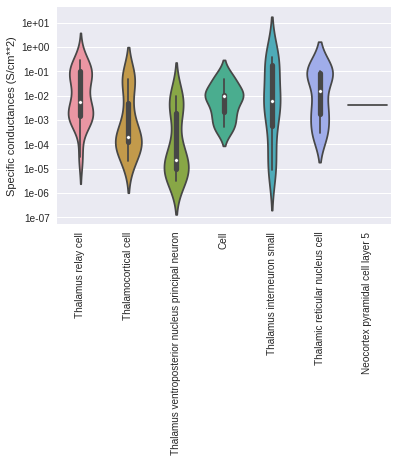

In [75]:
%matplotlib inline
import seaborn as sns
g = sns.violinplot(x="Cell", y="ValuesNorm", data=resultDF[resultDF["isSpecific"]], bw=0.5)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_xlabel("")

values  = g.get_yticks()
labels = [('%.0e' % 10**nb) for nb in values]
g.set_yticklabels(labels)
g.set_ylabel("Specific conductances (S/cm**2)")

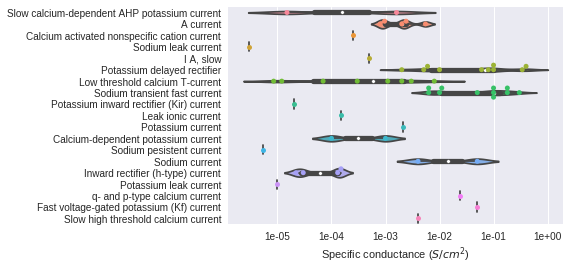

In [76]:
%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns
g = sns.violinplot(y="Transmembrane ionic current", x="ValuesNorm", 
                   data=resultDF[resultDF["isSpecific"]], bw=0.25)
g = sns.swarmplot(y="Transmembrane ionic current", x="ValuesNorm", 
                   data=resultDF[resultDF["isSpecific"]])
g.set_yticklabels(g.get_yticklabels())#, rotation=90)
g.set_ylabel("")
g.set_xlabel("Specific conductance ($S/cm^2$)")

values  = g.get_xticks()
labels = [('%.0e' % 10**nb) for nb in values]
g.set_xticklabels(labels) #x, labels, rotation='vertical')
plt.savefig('example_currents.png', bbox_inches='tight', transparent=True, dpi=200)

### Looking at resting membrane potential

In [78]:
from nat.annotationSearch import ParameterSearch, ConditionAtom

searcher = ParameterSearch(pathDB="neurocuratorDB")
searcher.setSearchConditions(ConditionAtom("Parameter name", "resting_membrane_potential"))
searcher.expandRequiredTags = True
searcher.onlyCentralTendancy = True

resultDF2 = searcher.search()
del resultDF2["obj_parameter"]
del resultDF2["obj_annotation"]
del resultDF2["Context"]
del resultDF2["Parameter instance ID"]
del resultDF2["Text"]
del resultDF2["Parameter type ID"]
del resultDF2["Result type"]

resultDF2.head()

,AgeCategories,Cell,Parameter name,Species,Unit,Values
0,[],Cell,resting_membrane_potential,[],mV,-60
1,[],Cell,resting_membrane_potential,"[{'name': 'Mouse', 'id': 'NIFORG:birnlex_167'}]",mV,-59.11
2,[],Thalamus relay cell,resting_membrane_potential,"[{'name': 'Rat', 'id': 'NIFORG:birnlex_160'}]",mV,-74.4
3,[],Thalamus relay cell,resting_membrane_potential,"[{'name': 'Rat', 'id': 'NIFORG:birnlex_160'}]",mV,-70.5
4,[],Thalamus interneuron small,resting_membrane_potential,"[{'name': 'Mouse', 'id': 'NIFORG:birnlex_167'}]",mV,-69


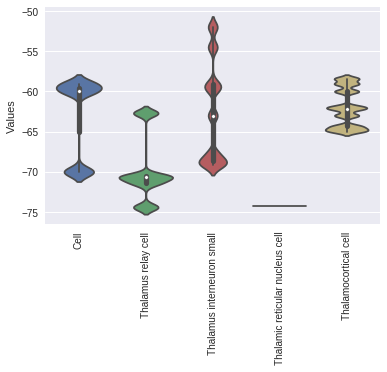

In [79]:
%matplotlib inline
import seaborn as sns
resultDF2["Values"] = [np.mean(val) for val in resultDF2["Values"]]
g = sns.violinplot(x="Cell", y="Values", data=resultDF2, bw=0.1)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_xlabel("")
#g.set_yscale("log")